## This the second part of the Covid-19 project.

### This notebook includes all the libraries installations and loading of the data from the first phase. After this, an experimentation of different forecasting techniques and a plethora of deep learning models are utilized for predicting Covid-19 disease as a time-series problem. In the deep learning approaches we include RNNs, LSTMs, TCNs, Attention Mechanisms and others.

### Intall the necessary libraries

In [1]:
! pip install keras_self_attention
! pip install keras-tcn==3.4.0

In [2]:
!pip install attention
!pip install keras-multi-head

### Import also the necessary libraries

In [3]:
import os, sys, pickle
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, SimpleRNN, GRU
from tcn import TCN, tcn_full_summary
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from keras_self_attention import SeqSelfAttention
from google.colab import drive, files
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import save
from numpy import load
import time
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
drive.mount('/content/gdrive', force_remount=True)
sys.path.append('/content/gdrive/My Drive')

Mounted at /content/gdrive


In [5]:
import metrics as mtr

### Load the data from the first phase

In [6]:
os.chdir('/content/gdrive/MyDrive/dataset')
Dates_reported = load('dates_reported.npy')
Daily_World_tests = load('daily_tests.npy')
Daily_World_cases = load('daily_cases.npy')
Daily_World_deaths = load('daily_deaths.npy')
##########################################
World_tests = load('world_tests.npy')
World_cases = load('world_cases.npy')
World_deaths = load('world_deaths.npy')
##########################################
italy_new_cases = load('italy_new_cases.npy')
italy_new_deaths = load('italy_new_deaths.npy')
italy_new_tests = load('italy_new_tests.npy')
italy_hosp = load('italy_hosp.npy')
italy_icu = load('italy_icu.npy')
italy_cum_cases = load('italy_cum_cases.npy')
italy_cum_tests = load('italy_cum_tests.npy')
##########################################
Daily_World_Positve_Rate = load('daily_positive_rate.npy')

In [7]:
with open('all_data.pkl', 'rb') as f:
    Overall_per_country = pickle.load(f)

### Process the data for inputting them to Neural Networks

In [8]:
def data_smoothing(cases_list,normal_factor,smoothness,divide_days):
  pos = np.where(cases_list> 0.95*np.amax(cases_list))
  #normal_factor = 100000 # we substract this amount
  #smoothness = 0.2 # in a precentage 80-20
  first_half = smoothness*normal_factor
  second_half = (1-smoothness)*normal_factor
  #divide_days = 150 # distribute on the first 150 meres and then to the rest
  kk = len(cases_list)-divide_days
  for j in range(len(pos[0])):
    cases_list[pos[0][j]] = cases_list[pos[0][j]] - 100000
    for i in range(len(cases_list)):
      if (i<kk):
        cases_list[i] = cases_list[i] + first_half/kk
      else:
        cases_list[i] = cases_list[i] + second_half/divide_days
  return (cases_list)

daily_world_cases = data_smoothing(Daily_World_cases,100000,0.2,130)

In [9]:
#World_cases ,World_deaths, World_tests,Daily_World_cases, Daily_World_deaths, Daily_World_tests, M_R_global_per_day, M_R_global_over_time,Total_cases,Total_deaths,Wcases_per_million,Wdeaths_per_million,Total_tests,Global_life_Exp,Daily_World_Positve_Rate,World_vaccines,Daily_World_vaccines
def make_datasets(Listf,Dates):
  for i in range(len(Listf)):
    Listf[i] = np.array(Listf[i])
    Listf[i].shape = (len(Listf[i]),1)
  Dates = np.array(Dates)
  Dates.shape = (len(Dates),1)
  total_data_perday = Listf[0]
  for i in range(len(Listf)-1):
    total_data_perday = np.concatenate((total_data_perday,Listf[i+1]), axis=1)
  total_data_perday = pd.DataFrame(data=total_data_perday)
  scl = MinMaxScaler(feature_range=(-1,1))
  return (total_data_perday,Dates,scl)

id = 103
id2 = 81
length = 429
id3 = 175
a = [World_cases, World_deaths, World_tests, daily_world_cases, Daily_World_tests, Daily_World_deaths, Daily_World_Positve_Rate] # World for cases
b = [Overall_per_country[id][7][-length:], Overall_per_country[id][8][-length:],Overall_per_country[id][9][-length:],Overall_per_country[id][10][-length:],Overall_per_country[id][11][-length:],Overall_per_country[id][12][-length:],
     Overall_per_country[id][13][-length:], Overall_per_country[id][14][-length:],Overall_per_country[id][15][-length:],Overall_per_country[id][17][-length:],Overall_per_country[id][18][-length:],
     Overall_per_country[id][19][0][-length:], Overall_per_country[id][19][1][-length:],Overall_per_country[id][19][2][-length:],Overall_per_country[id][19][3][-length:]] # Italy for deaths
c = [Overall_per_country[id2][7],Overall_per_country[id2][10],Overall_per_country[id2][11],Overall_per_country[id2][12],Overall_per_country[id2][13],Overall_per_country[id2][14],Overall_per_country[id2][15]]
d = [Overall_per_country[id3][7],Overall_per_country[id3][10],Overall_per_country[id3][11],Overall_per_country[id3][12],Overall_per_country[id3][13],Overall_per_country[id3][14],Overall_per_country[id3][15]]
World_total_data_perday,Dates_reported,scaler = make_datasets(a,Dates_reported)
Italy_total_data_per_day,Dates_reported,scaler = make_datasets(b,Dates_reported)
Greece_total_data_per_day,Dates_reported,scaler = make_datasets(c,Dates_reported)
Russia_total_data_per_day,Dates_reported,scaler = make_datasets(d,Dates_reported)

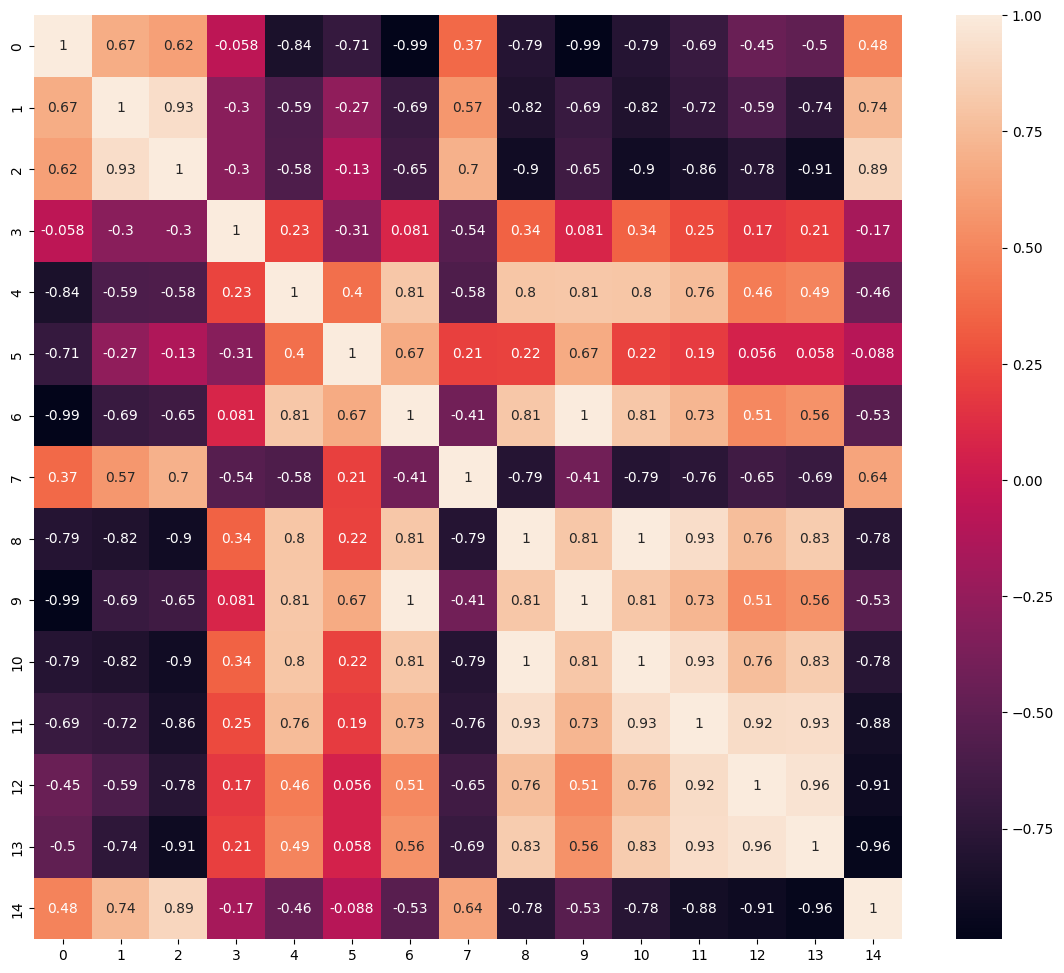

In [10]:
plt.figure(figsize=(14,12))
corrMatrix = Italy_total_data_per_day.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

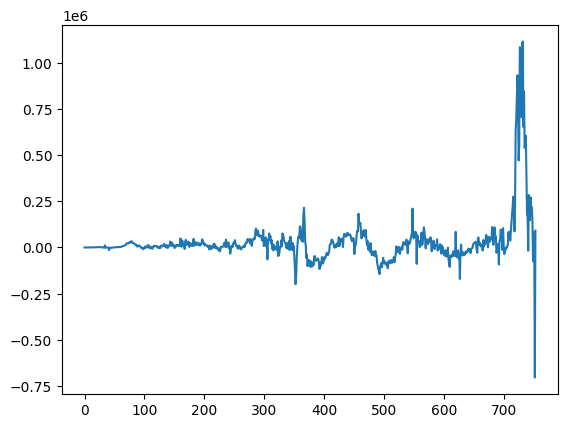

In [49]:
# create a difference dataset
def difference(data, order):
	return [data[i] - data[i - order] for i in range(order, len(data))]

dailyy_world_cases = difference(daily_world_cases,7)
plt.plot(dailyy_world_cases)
plt.show()

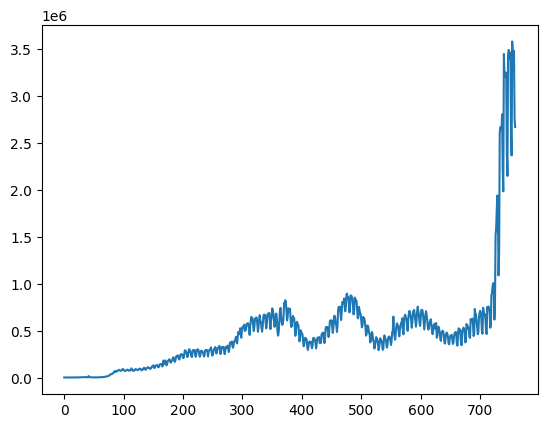

In [50]:
df = World_total_data_perday.filter([3])
plt.plot(daily_world_cases)
plt.show()

<Figure size 2000x1000 with 0 Axes>

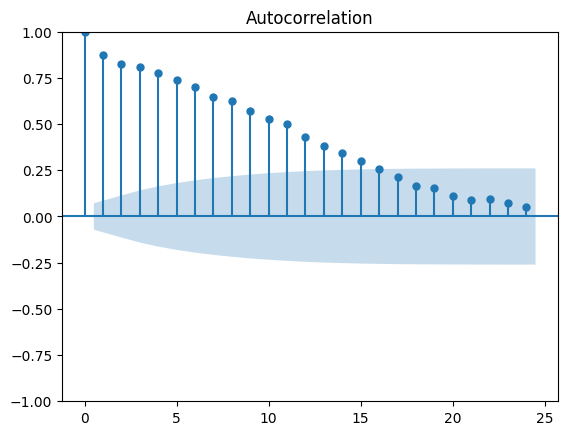

In [51]:
dd = np.array(dailyy_world_cases)
plt.figure(figsize=(20,10))
plot_acf(dd,lags=24,use_vlines=True)
plt.show()

In [45]:
data_a = Italy_total_data_per_day.filter([5])
data_b = World_total_data_perday.filter([4])
labels = data_a.values
feature_b = data_b.values
print(feature_b.shape)
#feature_c = data_c.values
#feature_d = data_d.values
feature_a = labels
#for i in range(len(labels)):
#  if (i==0):
#    feature_a.append('0')
#  else:
#    feature_a.append(labels[i-1][0])
labels = np.array([l[0] for l in labels])
feature_a = np.array([int (f) for f in feature_a])
#feature_b = np.array([f[0] for f in feature_b])
#feature_c = np.array([f[0] for f in feature_c])
#feature_d = np.array([f[0] for f in feature_d])
feature_a.shape = (len(feature_a),1)
#feature_b.shape = (len(feature_b),1)
#feature_c.shape = (len(feature_c),1)
#feature_d.shape = (len(feature_d),1)
labels.shape = (len(labels),1)
Features = feature_a
#Features = np.concatenate((feature_a,feature_b), axis=1)
log_labels = labels.copy()
log_Features = Features.copy()
for i in range(len(labels)):
  if (labels[i]>0):
    log_labels[i] = np.log(labels[i])
print(Features.shape)
for i in range(Features.shape[0]):
  for j in range(Features.shape[1]):
    if (Features[i,j]>0):
      log_Features[i,j] = np.log(Features[i,j])
Features_scaled = scaler.fit_transform(Features)
#Features_scaled = np.concatenate((Features_scaled,subscript), axis=1)
print(Features_scaled.shape)
labels_scaled = scaler.fit_transform(labels)
print(labels_scaled.shape)

(760, 1)
(429, 1)
(429, 1)
(429, 1)


<ipython-input-45-6ed2e65a936f>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  feature_a = np.array([int (f) for f in feature_a])


In [46]:
def make_subscript(array):
  subscript = np.zeros(len(array))
  for i in range(len(array)-1):
    if (abs(array[i+1]-array[i])>0.1*max(abs(array))):
      subscript[i] = 1
    if (i==len(array)-2):
      if (abs(array[i+1]-array[i])>0.01*max(abs(array))):
        subscript[i+1] = 1
  return (subscript)
subscript = make_subscript(np.array(labels))
subscript.shape = len(subscript),1

<class 'list'>
(422, 1)


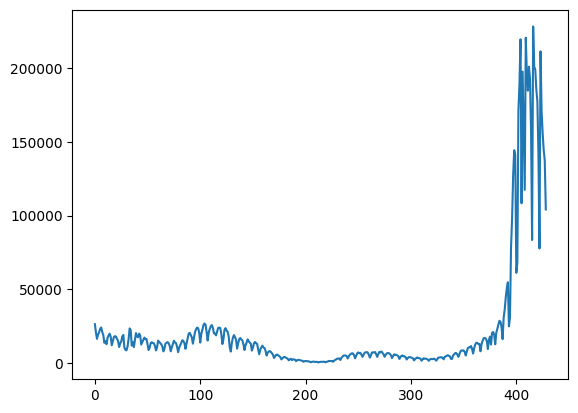

In [47]:
Labels = difference(labels,7)
print(type(Labels))
plt.plot(labels)
Features = Labels
#Features = np.concatenate((Labels,feature_b[7:]), axis=1)
Features_scaled = scaler.fit_transform(Features)
#Features_scaled = np.concatenate((Features_scaled,subscript), axis=1)
labels_scaled = scaler.fit_transform(Labels)
print(labels_scaled.shape)

### Experimentation of with Neural Networks

In [40]:
time_step = 15
training_data_len = int (np.round(len(labels)*0.9))
train_data = Features_scaled[0:training_data_len,:]
print((train_data.shape))
X_train = []
y_train = []
for i in range(time_step,len(train_data)):
  X_train.append(train_data[i-time_step:i])
  y_train.append(labels_scaled[i][0])
  #y_train.append(train_data[i][0])

X_train, y_train = np.array(X_train), np.array(y_train)
#X_train = np.reshape(X_train, (X_train.shape[0]),X_train.shape[1],1))
print((X_train.shape))
print((y_train.shape))

print("-------")
test_data = Features_scaled[training_data_len-time_step:,:]
print((test_data.shape))
X_test = []
y_test = np.array(labels)[training_data_len+int(time_step/2):,:]

for i in range(time_step, len(test_data)):
  X_test.append(test_data[i-time_step:i])

print(y_test.shape)
X_test = np.array(X_test)
print(X_test.shape)

(386, 1)
(371, 15, 1)
(371,)
-----
(51, 1)
(36, 1)
(36, 15, 1)


In [126]:
i = Input(shape=(X_train.shape[1],X_train.shape[2]))

o1 = TCN(nb_filters=256, kernel_size=4, dilations=(1, 2, 4), return_sequences=True, padding='causal')(i)  # The TCN layers are here.
o2 = TCN(nb_filters=12, kernel_size=2, dilations=(1, 2, 4), return_sequences=True, padding='causal')(o1)  # The TCN layers are here.
o3 = Dense(1)(o2)

model = Model(inputs=[i], outputs=[o3])
model.compile(optimizer='rmsprop', loss='mse')
model.summary()

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)          │ (None, 15, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ tcn_8 (TCN)                          │ (None, 15, 256)             │       1,313,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ tcn_9 (TCN)                          │ (None, 15, 12)              │          10,740 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 15, 1)               │              13 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,324,545 (5.05 MB)

 Trainable params: 1,324,545 (5.05 MB)

 Non-trainable params: 0 (0.00 B)

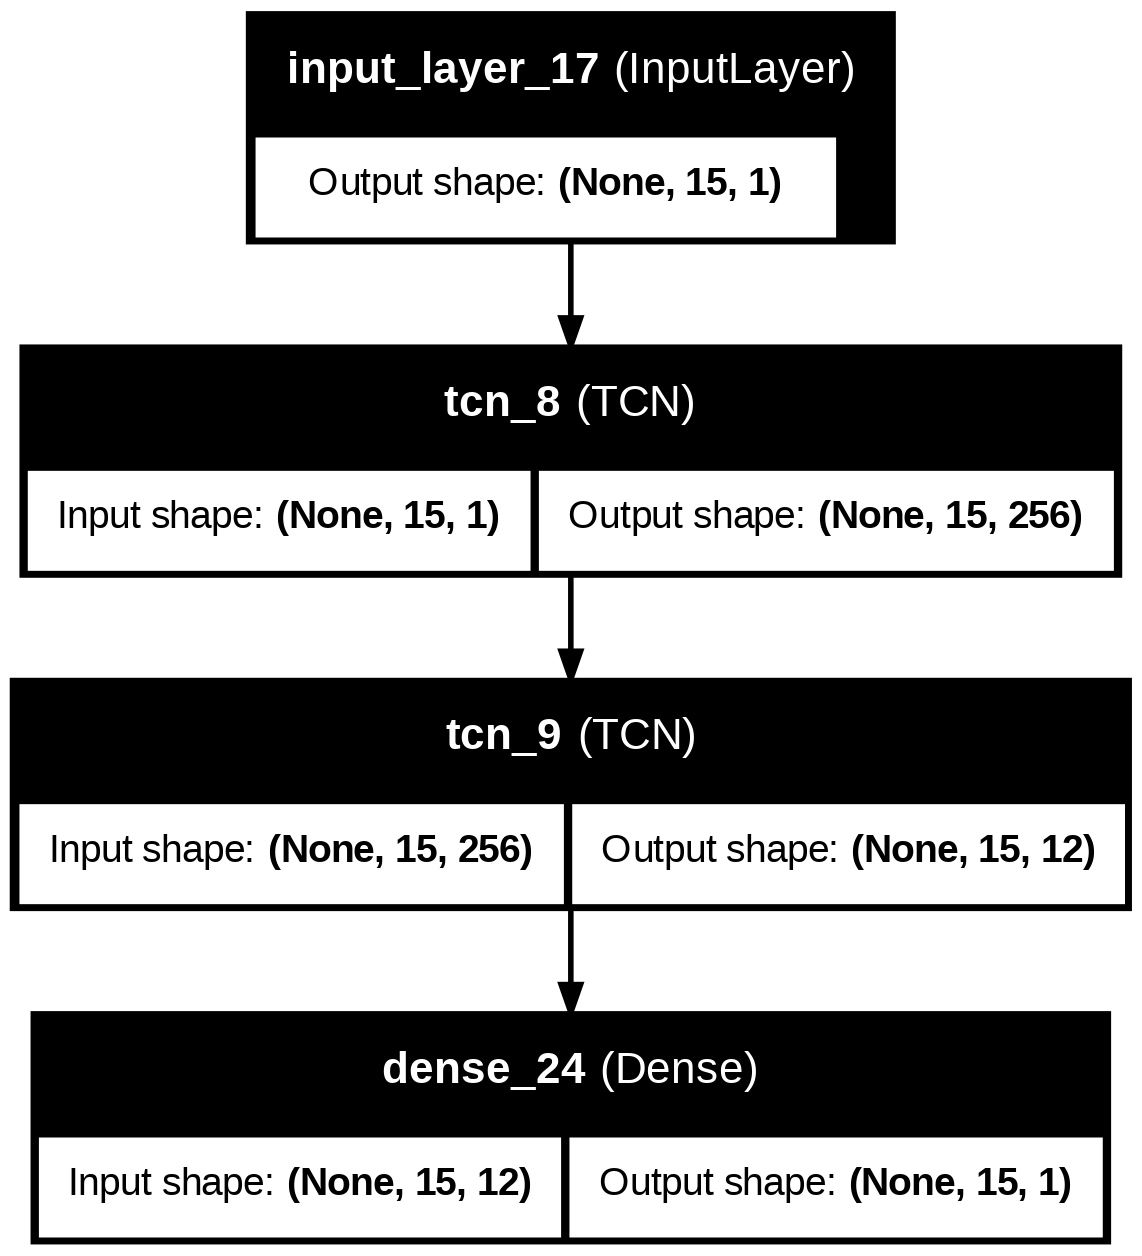

In [127]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=False)

In [128]:
t_start = time.time()
history = model.fit(X_train, y_train, batch_size=16, epochs=15, validation_split=0.1, shuffle=False)
t_finish = time.time()
print('Runtime: %.2f s' %(t_finish-t_start))

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_209']
Received: inputs=Tensor(shape=(None, 15, 1))
  warnings.warn(msg)


21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - loss: 19.2160 - val_loss: 0.0357
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - loss: 0.4312 - val_loss: 0.8217
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - loss: 0.3468 - val_loss: 0.1151
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - loss: 0.0788 - val_loss: 0.0420
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - loss: 0.1942 - val_loss: 0.0085
Epoch 6/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - loss: 0.0097 - val_loss: 0.0771
Epoch 7/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - loss: 0.0514 - val_loss: 0.0125
Epoch 8/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - loss: 0.0113 - val_loss: 0.0128
Epoch 9/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - loss: 0.0081 - val_loss: 0.0119
Epoch 10/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - loss: 0.0072 - val_loss: 0.0094
Epoch 11/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - loss: 0.0056 - val_loss: 0.0108
Epoch 12/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - loss: 0

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_209']
Received: inputs=Tensor(shape=(32, 15, 1))
  warnings.warn(msg)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 461ms/step
(36, 15, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
(36, 15, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
(36, 15, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
(36, 15, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
(36, 15, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
(36, 15, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
(36, 15, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
(36, 15, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
(36, 15, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
(36, 15, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
(36, 15, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
(36, 15, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
(36, 15, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
(36, 15, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
(36, 15, 1)


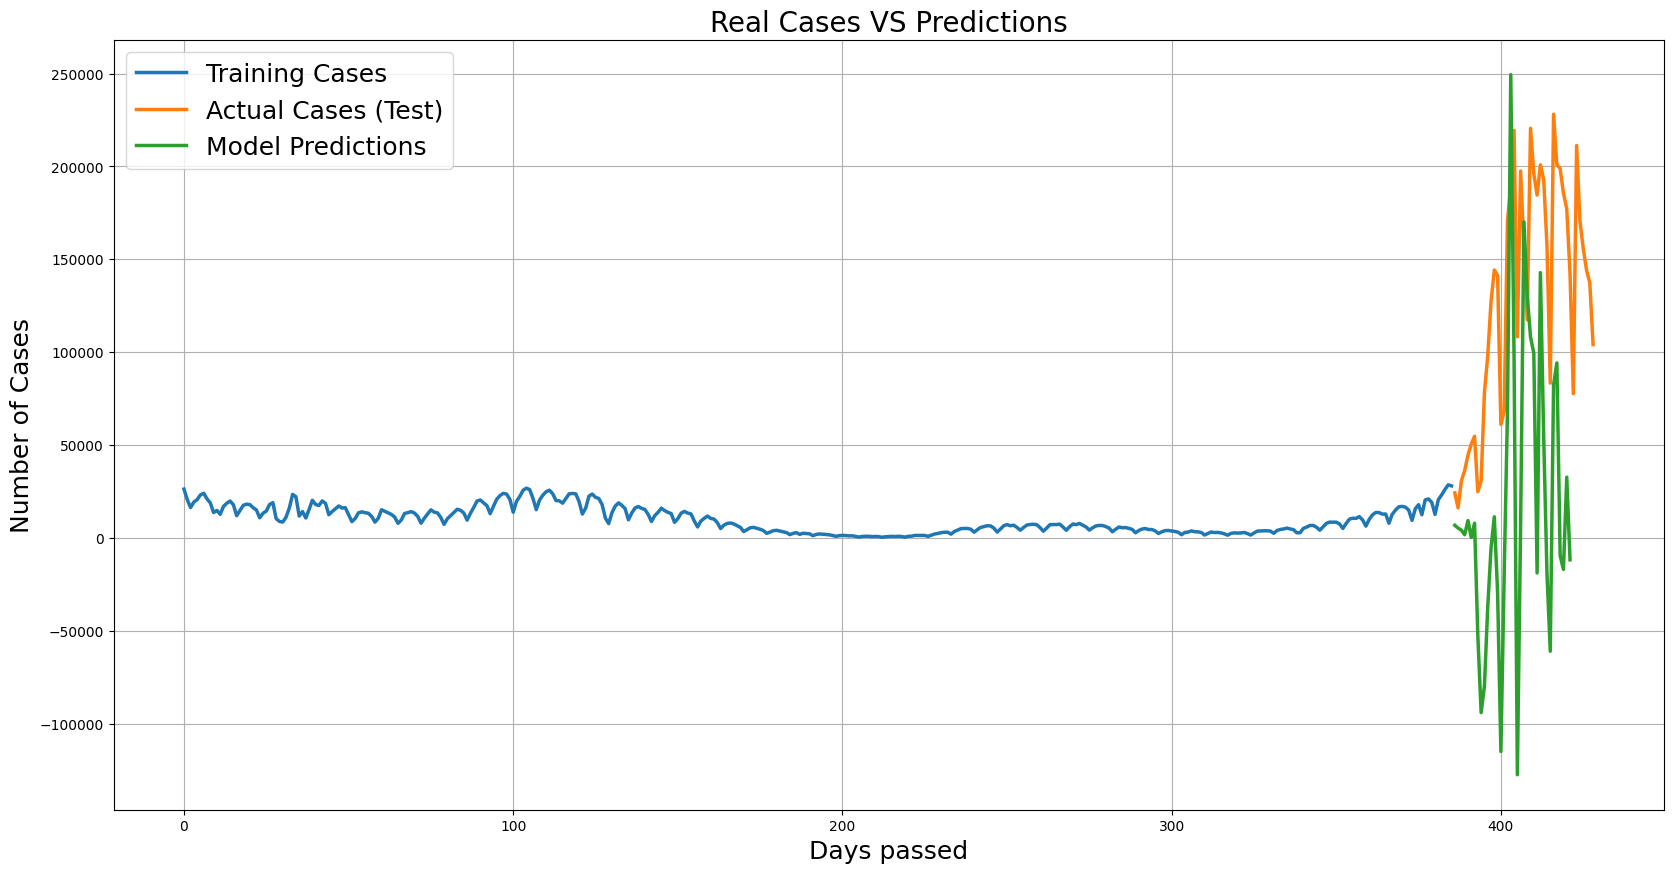

The R_squared value is:  -6.846
The root mean squared percentage error (RMSPE) is:  108.37 %
The mean absolute percentage error (MAPE) is:  97.17 %
Final Accuracy of TCN is:  2.83 %
The final RMSE is:  152510.0
The final MAE is:  134490.0


In [129]:
min_rmse = sys.maxsize
for i in range((X_test.shape[1])):
  predictions = model.predict(X_test)
  print(predictions.shape)
  predictions = scaler.inverse_transform(predictions[:,i,:])
  proper_predictions = predictions
  rmse = np.sqrt(np.mean((proper_predictions-y_test)**2))
  if (rmse < min_rmse):
    min_rmse = rmse
    final_predictions = proper_predictions

final_predictions = np.array([p[0] for p in final_predictions])
actuals,pred = mtr.plot_LSTM_pred_Keras(labels, final_predictions, training_data_len)
mtr.R_square(actuals,pred)
mtr.RMSPE(actuals,pred)
mtr.MAPE(final_predictions,actuals,0)
rmse = np.sqrt(np.mean(((final_predictions)-(actuals))**2))
real = list(actuals)
pred = list (pred)
print("Final Accuracy of TCN is: ", np.round(100-np.mean(mtr.accuracy_func([],real,pred[-len(y_test):])),2),"%")
print("The final RMSE is: ",np.round(rmse))
mae = np.mean(np.abs(final_predictions-actuals))
print("The final MAE is: ",np.round(mae))

In [75]:
first_input = train_data[-time_step:]
forecast_list = []
for i in range(30):
  if (len(first_input)>time_step):
    temp = first_input[-time_step:]
    model_input = temp.reshape(1,temp.shape[0],temp.shape[1])
    #model_input = temp.reshape(1,3,5,temp.shape[1],1)
    forecast = model.predict(model_input)
    real_forecast = scaler.inverse_transform(forecast[0,:,:])
    forecast_list.append(real_forecast[0,0])
    first_input = np.concatenate((first_input,forecast[0,:,:]), axis=0)
  else:
    model_input = first_input.reshape(1,first_input.shape[0],first_input.shape[1])
    forecast = model.predict(model_input)
    first_input = np.concatenate((first_input,forecast[0,:,:]), axis=0)
    real_forecast = scaler.inverse_transform(forecast[0,:,:])
    forecast_list.append(real_forecast[0,0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━

##### This part is about projecting prediction into the future beyond the horizon of the dataset. However here the results are incorrect. Please refer to the main notebook (final_version.ipynb) for more information and in the report.

459
(429, 1)


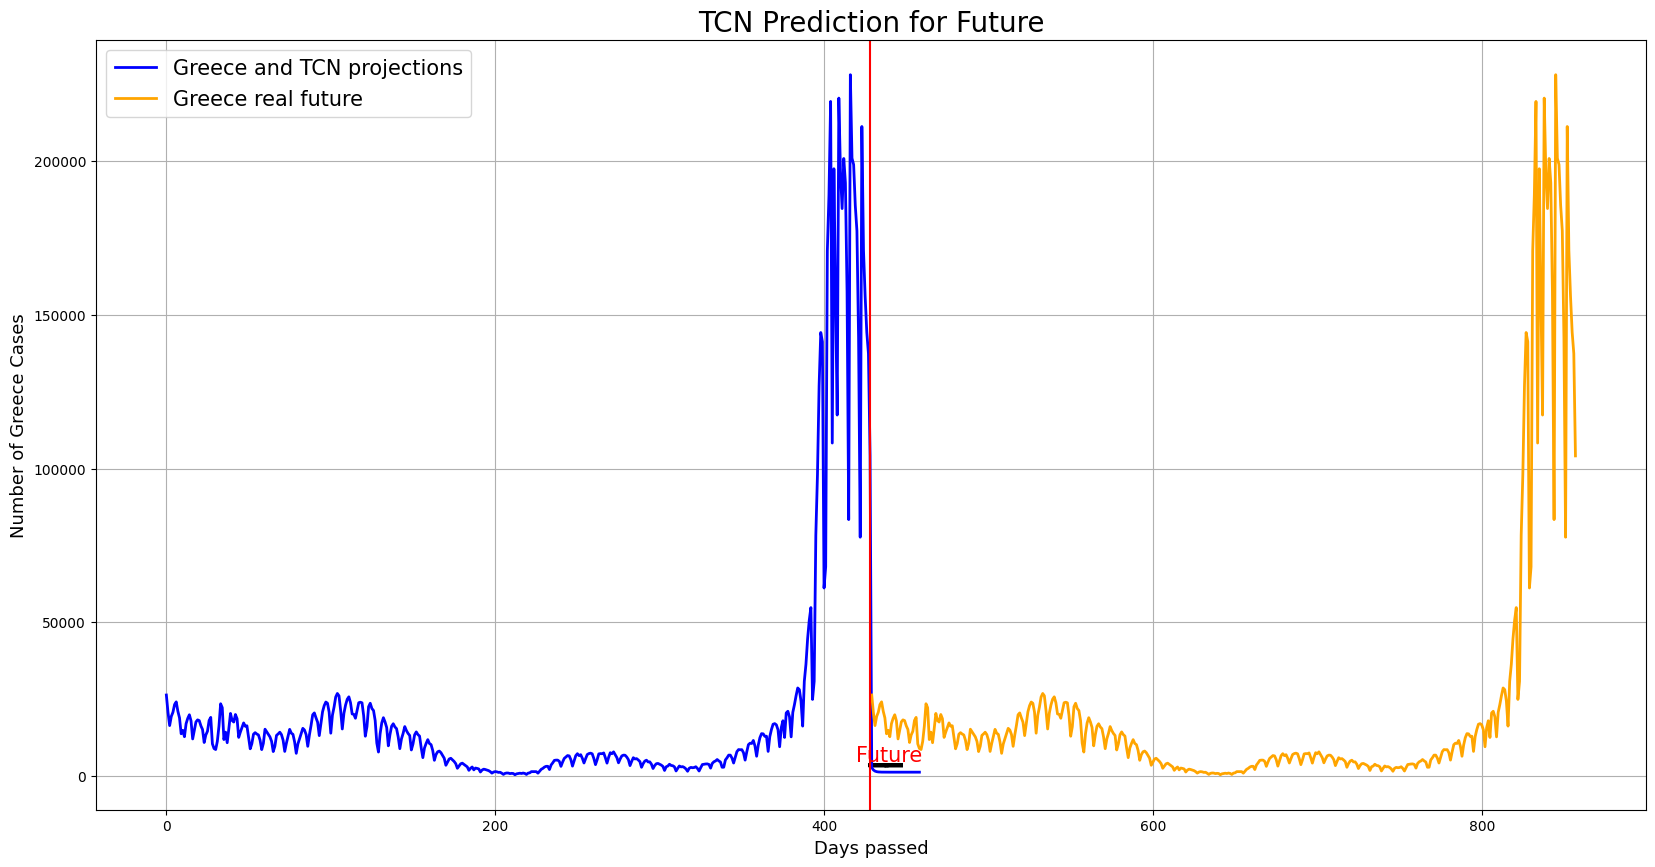

In [82]:
forecast_array = np.array(forecast_list)
forecast_array.shape = (len(forecast_array),1)
labels_with_forecast = np.concatenate((labels,forecast_array), axis=0)
print(len(labels_with_forecast))
plt.figure(figsize=(20,10))
plt.title("TCN Prediction for Future", fontsize=20)
plt.xlabel('Days passed', fontsize=13)
plt.ylabel('Number of Greece Cases', fontsize=13)
plt.plot(labels_with_forecast,color='blue',label='Greece and TCN projections',linewidth=2)
zeross=np.array([float('nan') for i in range(len(labels))])
print(labels.shape)
greece=np.concatenate((zeross, labels[:,0]),axis=0)
plt.plot(greece,color='orange',label='Greece real future',linewidth=2)
plt.axvline(x=428,color='r')
plt.arrow(428, 3500, 20, 0, length_includes_head=True,head_width=40, head_length=10, fc='k', ec='k', linewidth=3)
plt.text(460, 3520, 'Future',verticalalignment='bottom', horizontalalignment='right', color='red', fontsize=15)
plt.legend(loc='upper left',fontsize=15)
plt.grid(True)
plt.show()

In [88]:
model_kerass = Sequential()
#model_kerass.add(Attention(return_sequences=True))
#model_kerass.add((LSTM(units=32, return_sequences=True,recurrent_activation ='sigmoid', recurrent_dropout=0.0, input_shape=(X_train.shape[1],X_train.shape[2]))))
#model_kerass.add(Dropout(0.1))
#model_kerass.add(Attention(return_sequences=True))
#model_kerass.add((LSTM(units=512,return_sequences=True, recurrent_activation ='sigmoid',recurrent_dropout=0.0)))
model_kerass.add((GRU(units=512, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2]))))
model_kerass.add(Dropout(0.1))
model_kerass.add((GRU(units=128, recurrent_activation ='sigmoid', recurrent_dropout=0.0, unroll=False, use_bias=True, return_sequences=True)))
model_kerass.add(Dropout(0.1))
#model_kerass.add(LeakyReLU(alpha=0.2))
model_kerass.add(Flatten())
#model_kerass.add(Dense(units=128))
#model_kerass.add(Dense(units=32))
#model_kerass.add(Dense(units=8))
model_kerass.add(Dense(units=1))
#model_kerass.build(X_train.shape)
model_kerass.compile(optimizer='adam',loss='mean_squared_error')
model_kerass.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_5 (GRU)                          │ (None, 15, 512)             │         791,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 15, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_6 (GRU)                          │ (None, 15, 128)             │         246,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 15, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 1920)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │           1,921 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,039,489 (3.97 MB)

 Trainable params: 1,039,489 (3.97 MB)

 Non-trainable params: 0 (0.00 B)

In [112]:
t_start = time.time()
history = model_kerass.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.1, shuffle=False)
t_finish = time.time()
print('Runtime: %.2f s' %(t_finish-t_start))

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - loss: 0.0015 - val_loss: 0.0070
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - loss: 0.0018 - val_loss: 0.0067
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 292ms/step - loss: 0.0018 - val_loss: 0.0066
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 316ms/step - loss: 0.0018 - val_loss: 0.0065
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - loss: 0.0019 - val_loss: 0.0063
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - loss: 0.0020 - val_loss: 0.0061
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - loss: 0.0018 - val_loss: 0.0061
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 425ms/step - loss: 0.0020 - val_loss: 0.0062
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 362ms/step - loss: 0.0018 - val_loss: 0.0062
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - loss: 0.0018 - val_loss: 0.0061
Runtime: 31.08 s


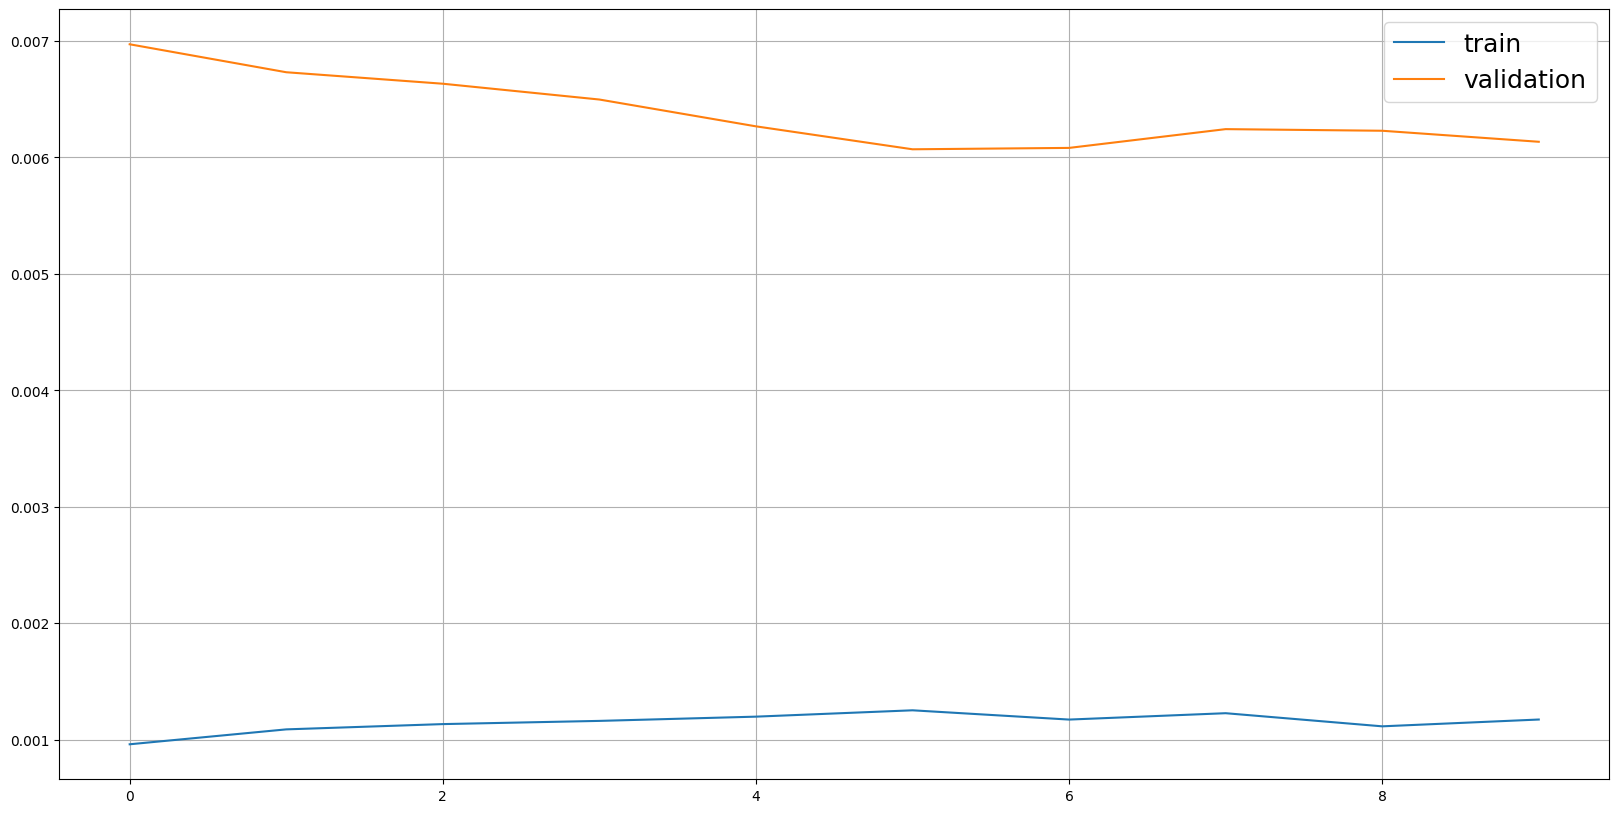

In [115]:
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend(fontsize=18)
plt.grid(True)
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


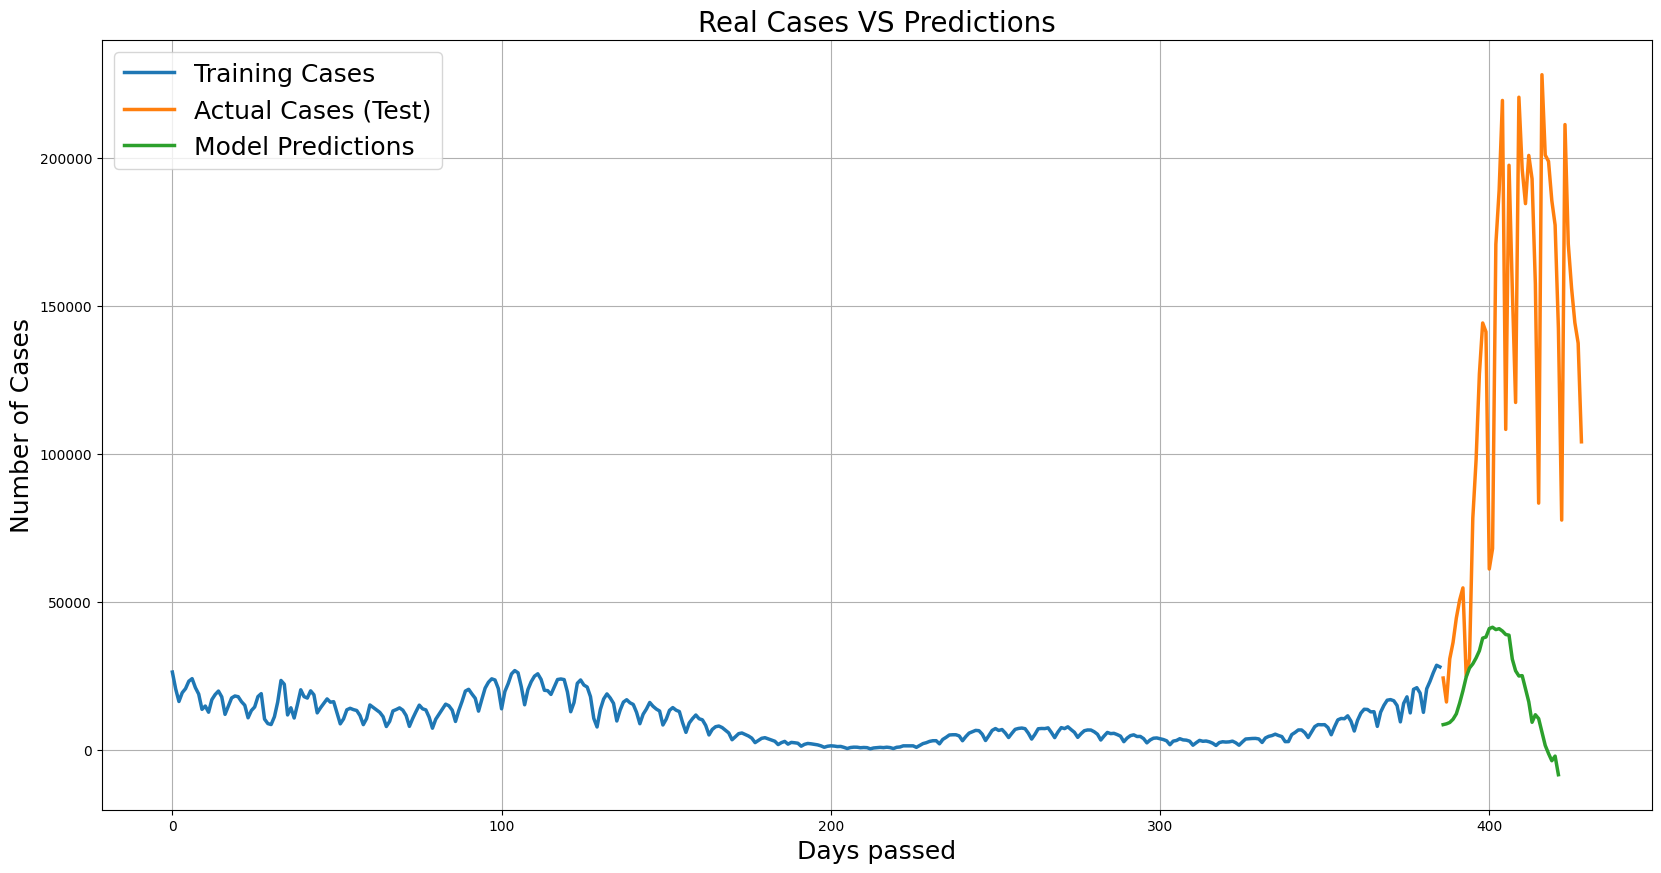

The R_squared value is:  -5.259
The root mean squared percentage error (RMSPE) is:  84.78 %
The mean absolute percentage error (MAPE) is:  83.92 %
Final Accuracy of the GRU is:  16.08 %
The final RMSE is:  136212.0
The final MAE is:  126261.0


In [117]:
FLAG = True
if (FLAG):
  min_rmse = sys.maxsize
  for i in range((15)):
    predictions = model_kerass.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    proper_predictions = predictions
    #proper_predictions = predictions + labels[380:422]
    #rmse = np.mean(np.abs(predictions-y_test))
    rmse = np.sqrt(np.mean((proper_predictions-y_test)**2))
    if (rmse < min_rmse):
      min_rmse = rmse
      final_predictions = proper_predictions
  final_predictions = np.array([p[0] for p in final_predictions])

actuals,pred = mtr.plot_LSTM_pred_Keras(labels,predictions[:,0],training_data_len)
rmse = np.sqrt(np.mean(((pred)-(actuals))**2))
mtr.R_square(actuals,pred)
mtr.RMSPE(actuals,pred)
mtr.MAPE(pred,actuals,0)
real =  list (actuals)
pred = list (pred)
print("Final Accuracy of the GRU is: ", np.round(100-np.mean(mtr.accuracy_func([],real,pred[-len(y_test):])),2),"%")
print("The final RMSE is: ", np.round(rmse))
mae = np.mean(np.abs(pred-actuals))
print("The final MAE is: ",np.round(mae))

In [118]:
class Attentionn(Layer):

    def __init__(self, divide=None, return_sequences=True):
        self.return_sequences = return_sequences
        self.divide = divide
        super().__init__()

    def build(self, input_shape1):

        self.W=self.add_weight(name="att_weight1", shape=(input_shape1[-1]-self.divide,1),initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape1[1],1),initializer="zeros")
        self.V=self.add_weight(name="att_mul", shape=(input_shape1[1],1),initializer="normal")
        self.U=self.add_weight(name="att_weight2", shape=(self.divide,1),initializer="normal")
        super().build(input_shape1)

    def call(self, x):
        temp = x.shape[-1] - self.divide
        e = self.V*(K.tanh(K.dot(x[:,:,0:-self.divide],self.W) + K.dot(x[:,:,temp:],self.U) + self.b))
        a = K.softmax(e, axis=1)
        output = x[:,:,0:self.divide]*a

        if self.return_sequences:
            return output

        return K.sum(output, axis=1)

def rotate(l, n):
    return ((l[n:] + l[:n]))

In [119]:
input = Input(shape=(X_train.shape[1],X_train.shape[2]))
h1,h2,c1 = (LSTM(units=512, return_sequences=True, return_state=True))(input)
lstm1 = concatenate([h2,c1])
rv = RepeatVector(n=X_train.shape[1])(lstm1)
attention = Attentionn(512,return_sequences=True)(rv)
x = concatenate([h1,attention])
lstm2 = (GRU(256,return_sequences=True))(x)
drop = Dropout(0.1)(lstm2)
dense = Dense(32)(drop)
out = Dense(1)(dense)
my_model = Model(inputs=input, outputs=out)
my_model.summary()
my_model.compile(loss='mean_squared_error', optimizer='adam')

Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16            │ (None, 15, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_6 (LSTM)             │ [(None, 15, 512),      │      1,052,672 │ input_layer_16[0][0]   │
│                           │ (None, 512), (None,    │                │                        │
│                           │ 512)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_12            │ (None, 1024)           │              0 │ lstm_6[0][1],          │
│ (Concatenate)             │                        │                │ lstm_6[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_6           │ (None, 15, 1024)       │              0 │ concatenate_12[0][0]   │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attentionn_6 (Attentionn) │ (None, 15, 512)        │          1,054 │ repeat_vector_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_13            │ (None, 15, 1024)       │              0 │ lstm_6[0][0],          │
│ (Concatenate)             │                        │                │ attentionn_6[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_13 (GRU)              │ (None, 15, 256)        │        984,576 │ concatenate_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 15, 256)        │              0 │ gru_13[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 15, 32)         │          8,224 │ dropout_13[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_23 (Dense)          │ (None, 15, 1)          │             33 │ dense_22[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,046,559 (7.81 MB)

 Trainable params: 2,046,559 (7.81 MB)

 Non-trainable params: 0 (0.00 B)

In [123]:
t_start = time.time()
history = my_model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.1, shuffle=False)
t_finish = time.time()
print('Runtime: %.2f s' %(t_finish-t_start))

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 321ms/step - loss: 0.0017 - val_loss: 0.0111
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - loss: 0.0017 - val_loss: 0.0110
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 415ms/step - loss: 0.0017 - val_loss: 0.0111
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 331ms/step - loss: 0.0017 - val_loss: 0.0112
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - loss: 0.0017 - val_loss: 0.0111
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 470ms/step - loss: 0.0017 - val_loss: 0.0110
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 315ms/step - loss: 0.0017 - val_loss: 0.0110
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 319ms/step - loss: 0.0017 - val_loss: 0.0111
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 438ms/step - loss: 0.0017 - val_loss: 0.0112
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 361ms/step - loss: 0.0017 - val_loss: 0.0111
Runtime: 46.32 s


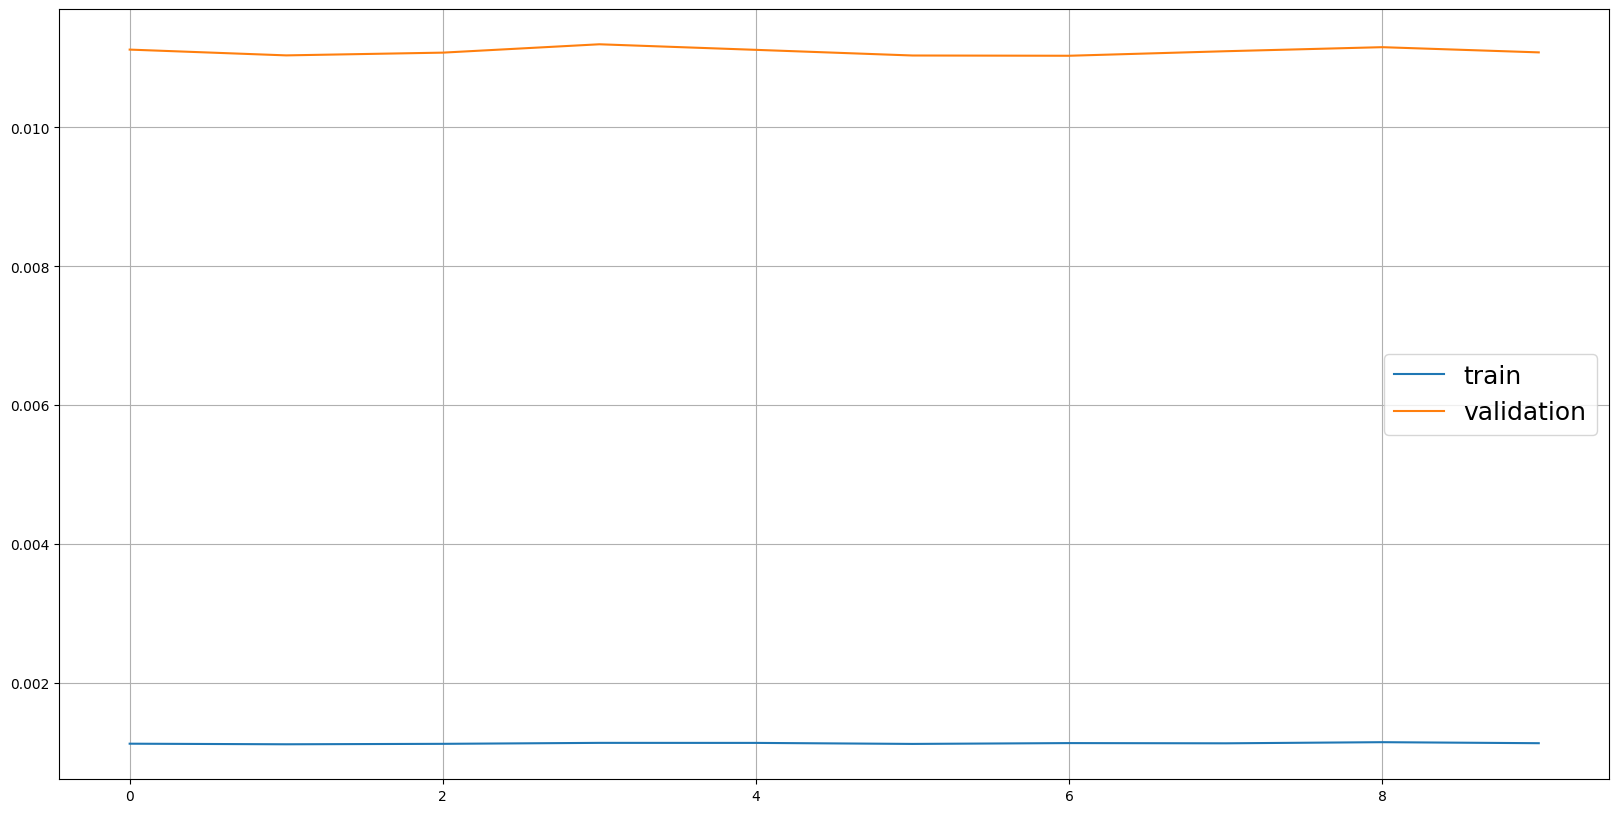

In [124]:
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend(fontsize=18)
plt.grid(True)
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step 


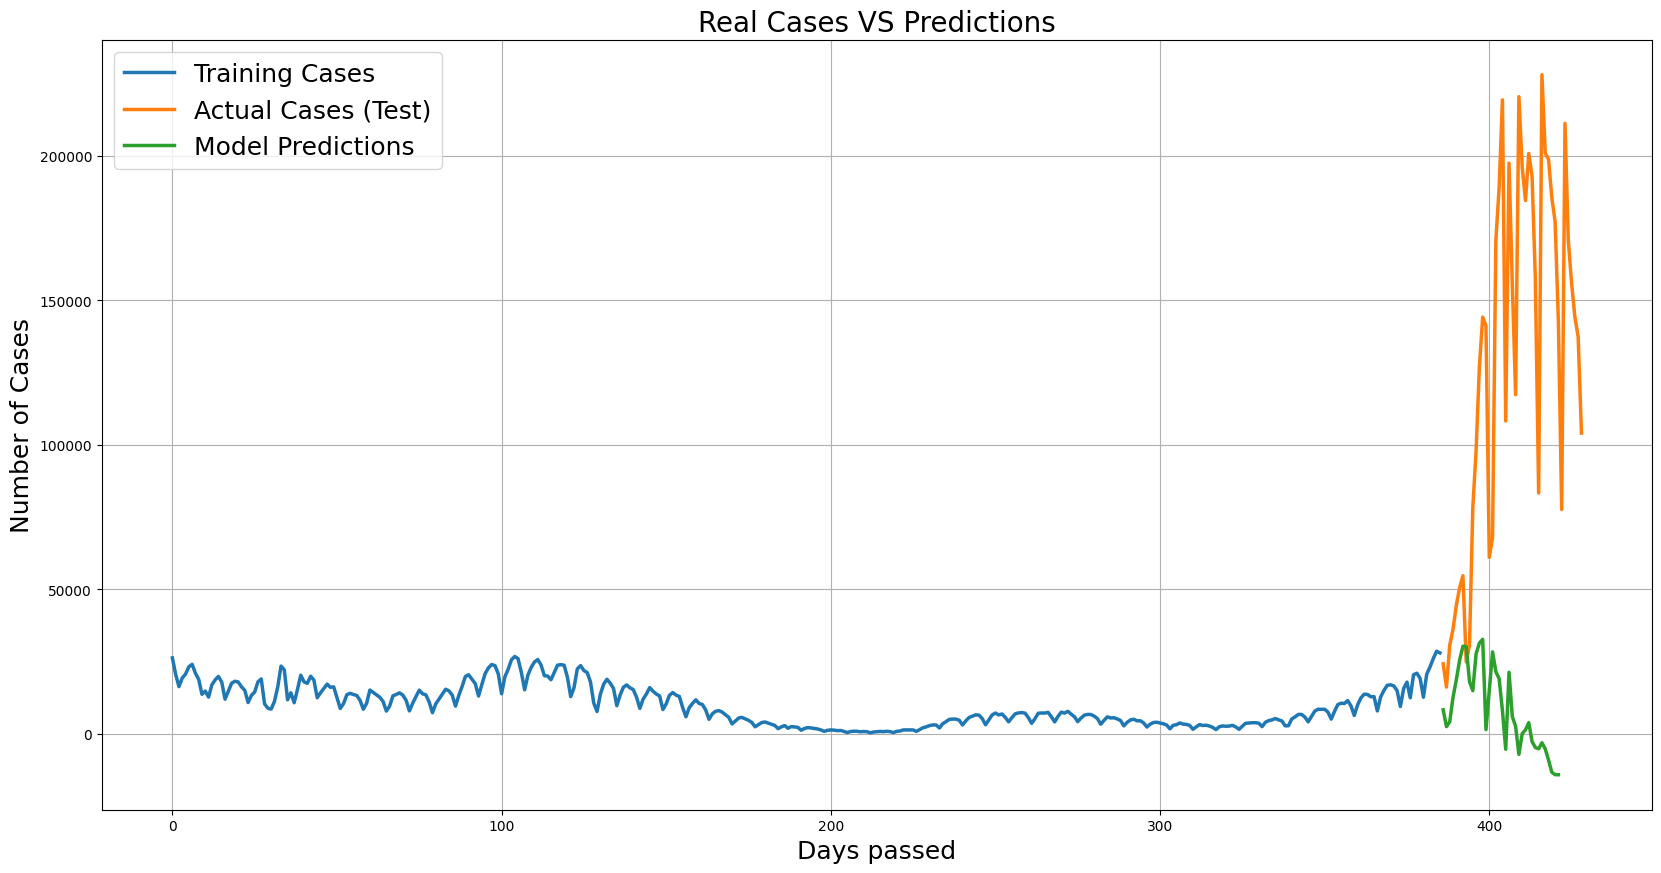

The R_squared value is:  -6.599
The root mean squared percentage error (RMSPE) is:  93.25 %
The mean absolute percentage error (MAPE) is:  92.3 %
Final Accuracy of the Model is:  7.7 %
The final RMSE is:  150088.0
The final MAE is:  138884.0


In [125]:
FLAG = True
if (FLAG):
  min_rmse = sys.maxsize
  for i in range((15)):
    predictions = my_model.predict(X_test)
    predictions = scaler.inverse_transform(predictions[:,i,:])
    proper_predictions = predictions
    rmse = np.sqrt(np.mean((proper_predictions-y_test)**2))
    if (rmse < min_rmse):
      min_rmse = rmse
      final_predictions = proper_predictions
  final_predictions = np.array([p[0] for p in final_predictions])


actuals,pred = mtr.plot_LSTM_pred_Keras(labels,predictions[:,0],training_data_len)
rmse = np.sqrt(np.mean(((pred)-(actuals))**2))
mtr.R_square(actuals,pred)
mtr.RMSPE(actuals,pred)
mtr.MAPE(pred,actuals,0)
real =  list (actuals)
pred = list (pred)
print("Final Accuracy of the Model is: ", np.round(100-np.mean(mtr.accuracy_func([],real,pred[-len(y_test):])),2),"%")
print("The final RMSE is: ", np.round(rmse))
mae = np.mean(np.abs(pred-actuals))
print("The final MAE is: ",np.round(mae))

### This part corresponds to the last experiment of the Thesis, where we are trying to extract geographical characterstics of the pandemic.

In [133]:
t_start = time.time()
alist = [2,5,16,42,55,61,67,96,98,108,137,159,175,188,204,218]
for k,j in enumerate(alist):
  country = j
  b = [Overall_per_country[country][7][:500],Overall_per_country[country][8][:500],Overall_per_country[country][9][:500],Overall_per_country[country][10][:500],Overall_per_country[country][11][:500],Overall_per_country[country][12][:500],Overall_per_country[country][13][:500],Overall_per_country[country][14][:500],Overall_per_country[country][15][:500],Overall_per_country[country][17][:500],Overall_per_country[country][18][:500]]
  Dataset,Dates_reported,scaler = make_datasets(b,Dates_reported)
  name = Overall_per_country[country][0]
  data = Dataset.filter([5])
  dataset = data.values
  other = Dataset.filter([0,1,2,4,6,7,8,9,10])
  other = other.values
  features = np.concatenate((dataset,other), axis=1)
  subscript = make_subscript(dataset)
  subscript.shape = (len(subscript),1)
  time_step = 15
  training_data_len = int (np.round(len(dataset)*1))
  scaled_data = scaler.fit_transform(dataset)

  train_data = scaled_data[0:training_data_len,:]
  X_train = []
  y_train = []
  for i in range(time_step,len(train_data)):
    X_train.append(train_data[i-time_step:i])
    y_train.append(train_data[i][0])

  X_train, y_train = np.array(X_train), np.array(y_train)
  print("The", k+1 ,"country starts, with name:", name)
  #train the GRU model
  history = model_kerass.fit(X_train,y_train, batch_size=16, epochs=3, validation_split=0.1, shuffle=False, verbose=2)
t_finish = time.time()
print('Runtime: %.2f s' %(t_finish-t_start))

The 1 country starts, with name: Algeria
(485, 15, 1)
(485,)
Epoch 1/3
29/29 - 6s - 199ms/step - loss: 0.0177 - val_loss: 0.0017
Epoch 2/3
29/29 - 3s - 115ms/step - loss: 0.0169 - val_loss: 0.0015
Epoch 3/3
29/29 - 5s - 169ms/step - loss: 0.0188 - val_loss: 0.0018
The 2 country starts, with name: Angola
(485, 15, 1)
(485,)
Epoch 1/3
29/29 - 5s - 183ms/step - loss: 0.0486 - val_loss: 0.4314
Epoch 2/3
29/29 - 8s - 278ms/step - loss: 0.0466 - val_loss: 0.2971
Epoch 3/3
29/29 - 4s - 131ms/step - loss: 0.0408 - val_loss: 0.1556
The 3 country starts, with name: Bangladesh
(485, 15, 1)
(485,)
Epoch 1/3
29/29 - 4s - 121ms/step - loss: 0.0157 - val_loss: 0.0165
Epoch 2/3
29/29 - 3s - 107ms/step - loss: 0.0220 - val_loss: 0.0153
Epoch 3/3
29/29 - 6s - 199ms/step - loss: 0.0184 - val_loss: 0.0146
The 4 country starts, with name: China
(485, 15, 1)
(485,)
Epoch 1/3
29/29 - 4s - 127ms/step - loss: 0.0198 - val_loss: 7.2498e-04
Epoch 2/3
29/29 - 3s - 110ms/step - loss: 0.0115 - val_loss: 0.0020
Epoc

In [135]:
country=52
b = [Overall_per_country[country][7][:500],Overall_per_country[country][8][:500],Overall_per_country[country][9][:500],Overall_per_country[country][10][:500],Overall_per_country[country][11][:500],Overall_per_country[country][12][:500],Overall_per_country[country][13][:500],Overall_per_country[country][14][:500],Overall_per_country[country][15][:500],Overall_per_country[country][17][:500],Overall_per_country[country][18][:500]] # Italy for deaths
Dataset,Dates_reported,scaler = make_datasets(b,Dates_reported)
data = Dataset.filter([5])
dataset = data.values
other = Dataset.filter([0,1,2,3,4,6,7,8,9,10])
other = other.values
features = np.concatenate((dataset,other), axis=1)
subscript = make_subscript(dataset)
subscript.shape = (len(subscript),1)

time_step = 15
training_data_len = int (np.round(len(dataset)*1))
scaled_data = scaler.fit_transform(dataset)

test_data = scaled_data[0:training_data_len,:]
X_test = []
y_test = []
for i in range(time_step,len(train_data)):
  X_test.append(test_data[i-time_step:i])
  y_test.append(test_data[i][0])

X_test, y_test = np.array(X_test), np.array(y_test)
#X_train = np.reshape(X_train, (X_train.shape[0]),X_train.shape[1],1))
print((X_test.shape))
print(y_test.shape)

(485, 15, 1)
(485,)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step
78.0


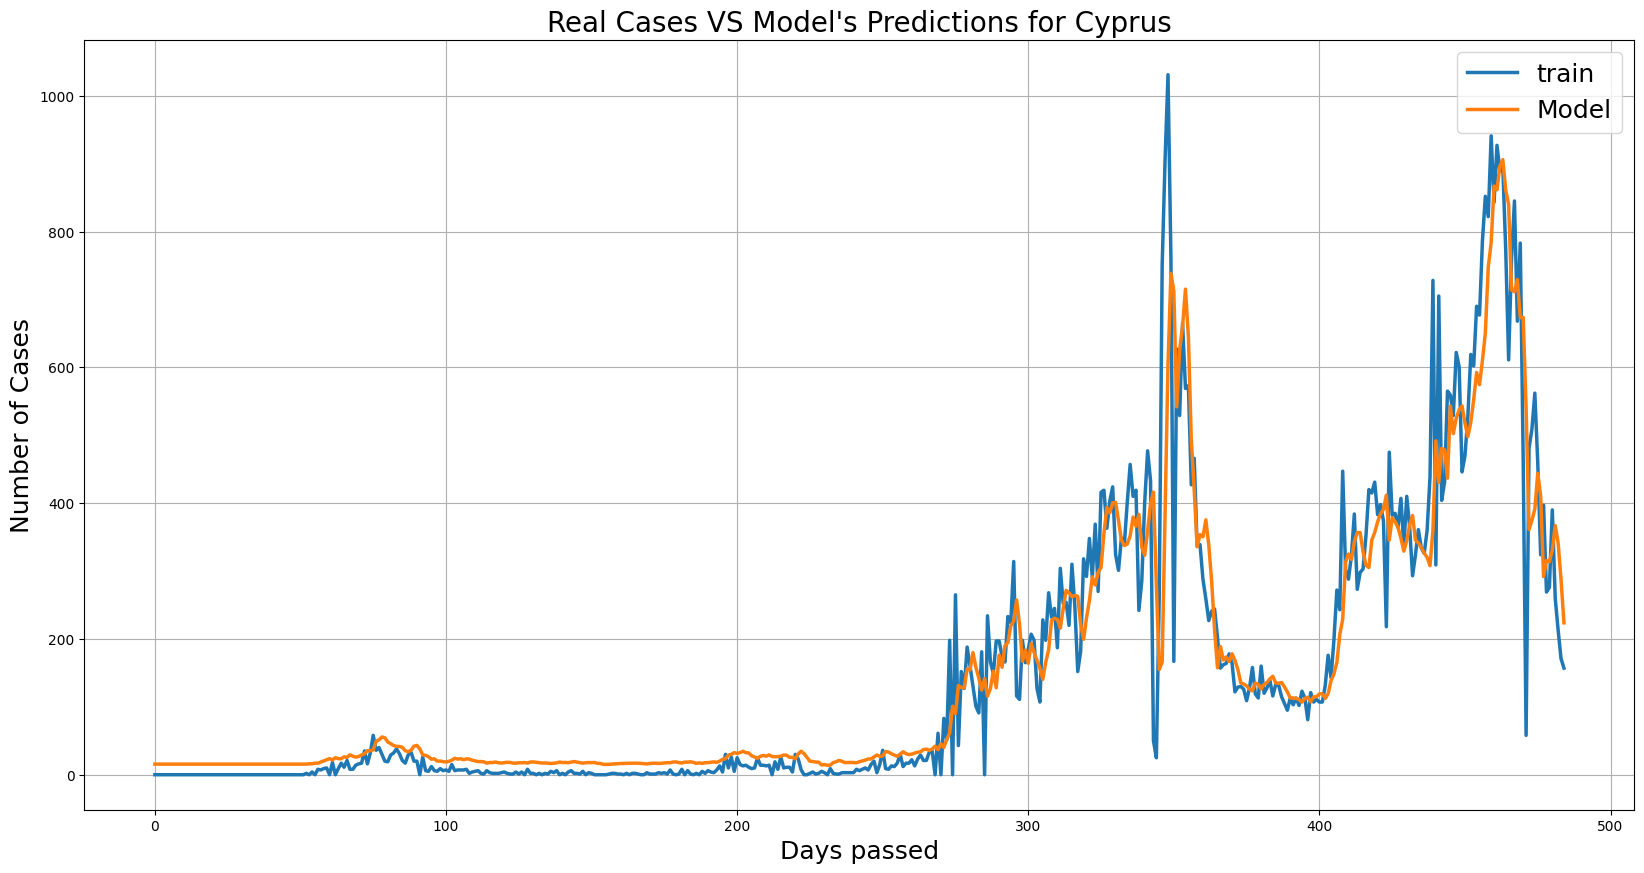

In [140]:
#predict cases, deaths and tests with the model
predictions = model_kerass.predict(X_test)
predictions_copies = np.repeat(predictions,1,axis=-1)
predictions = scaler.inverse_transform(predictions_copies)
predictions=np.array([p for p in predictions])
plt.figure(figsize=(20,10))
plt.title("Real Cases VS Model's Predictions for Cyprus", fontsize=20)
plt.xlabel('Days passed', fontsize=18)
plt.ylabel('Number of Cases', fontsize=18)
plt.plot(dataset[15:,0],label='train',linewidth=2.5)
plt.plot(predictions[:,0],label='Model',linewidth=2.5)
plt.legend(fontsize=18)
plt.grid(True)
rmse = np.sqrt(np.mean((dataset[15:,0]-predictions[:,0])**2))
print(np.round(rmse))